# Part 1

In [1]:
import pydub
import numpy as np
import sounddevice as sd
import cmath
from matplotlib import pyplot as plt
from scipy.io.wavfile import read, write
from math import e

## Class Music for music standard I/O

In [2]:
class Music: # static class for music I/O standard
    
    @staticmethod
    def plotter(x=None, y=None, title="", xlabel="", ylabel="", figsize=(20, 12), subplt=(1, 1, 1)):
        """
            East plotter
        """
        if x is None:
            x = np.arange(y.shape[0])
        plt.figure(figsize=figsize)
        plt.subplot(subplt)
        plt.plot(x, y)
        
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        return
    
    @staticmethod
    def frequencies(x, fs):
        """
            Audio vector to frequencies with FFT ratio
        """
        Fd = np.fft.fft(x)
        Fx = np.linspace(0, 1, max(x.shape))*fs
        return Fd, Fx
    
    @staticmethod
    def read_mp3(filename, normalized=False):
        """
            MP3 to numpy array
        """
        a = pydub.AudioSegment.from_mp3(filename)
        y = np.array(a.get_array_of_samples())
        if a.channels == 2:
            y = y.reshape((-1, 2))
        if normalized:
            return a.frame_rate, np.float32(y) / 2**15
        else:
            return a.frame_rate, y
    
    @staticmethod
    def write_mp3(filename, Fs, x, normalized=False):
        """ 
            numpy array to MP3 
        """
        channels = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
        if normalized:  
            y = np.int16(x * 2 ** 15)
        else:
            y = np.int16(x)
        song = pydub.AudioSegment(y.tobytes(), frame_rate=Fs, sample_width=2, channels=channels)
        song.export(filename, format="mp3", bitrate="320k")
        return
    
    
# plotter function
def freqplot(y, fs, N, t1="The signal", t2="Frequency"):

    x = np.linspace(0, y.shape[0]/fs, y.shape[0]) # Zero to 2*pi, one period
    f = np.fft.fft(y)
    p = np.linspace(0, fs, y.shape[0])

    plt.figure(figsize=(30, 10))
    
    plt.subplot(2, 1, 1)
    plt.plot(x, y)
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(t1)
    
    plt.subplot(2, 1, 2)
    plt.plot(p[:N], np.abs(f[:N]))
    plt.grid(True)
    plt.xlabel("Frequency")
    plt.title(t2)
    plt.show()
    

# butterworth filter
from scipy.signal import butter, lfilter, freqz

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

## Filtering the noise of file "noisy.wav"

In [3]:
from scipy.io import wavfile
fs, data = wavfile.read('musics/noisy.wav')
sd.play(data[:100000], fs) # x0.5 speed
sd.wait() 

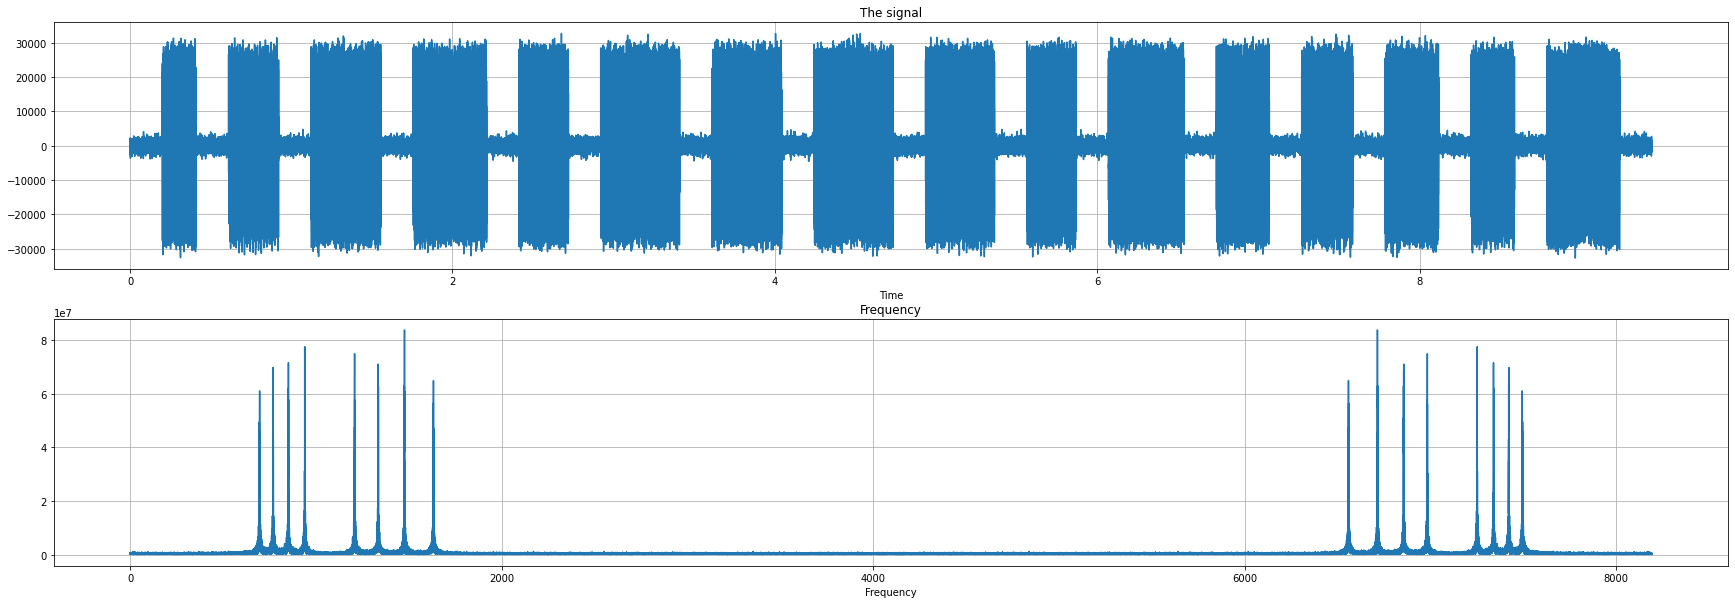

In [4]:
length = data.shape[0]/fs
t = np.linspace(0, length, data.shape[0])
data_fft = np.fft.fft(data)
p = np.linspace(0, fs, data.shape[0])
freqplot(data, fs, data.shape[0])

Making a bandpass filter in order to filter the noise:

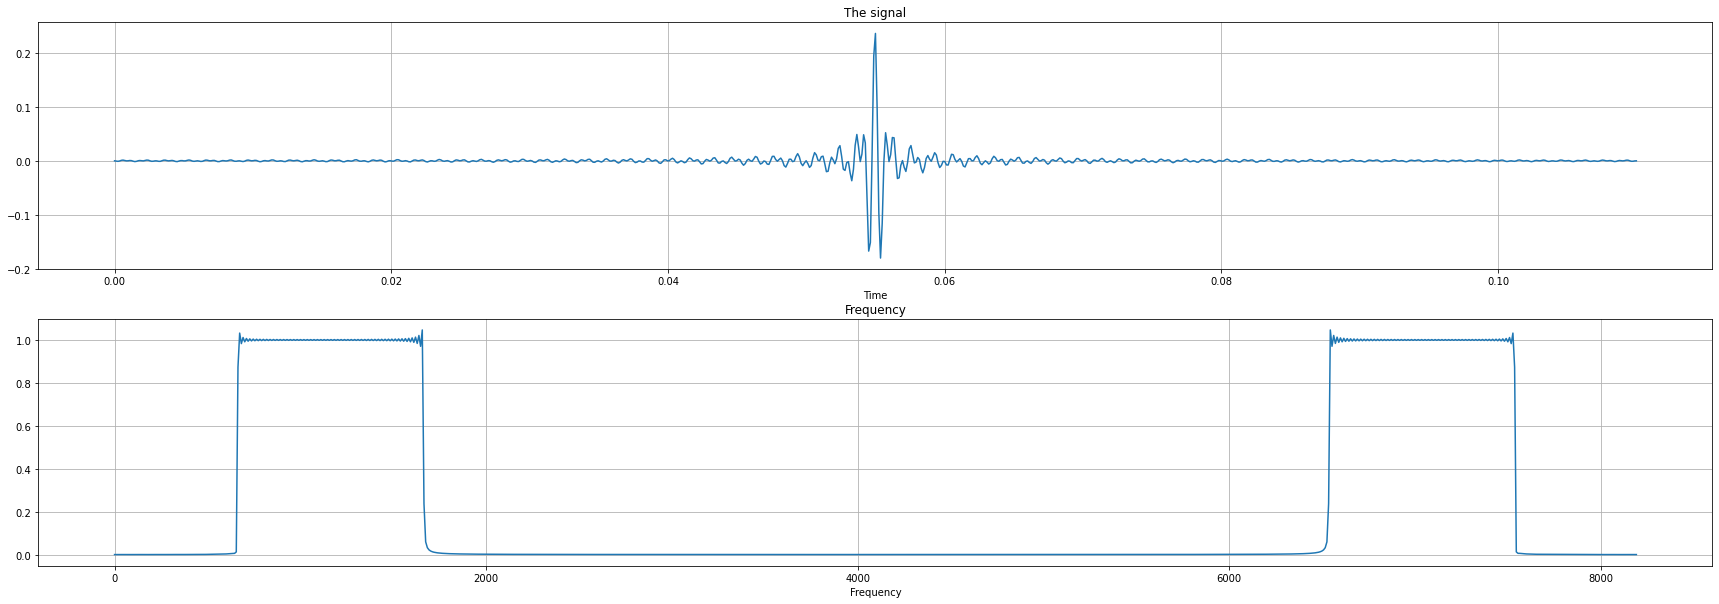

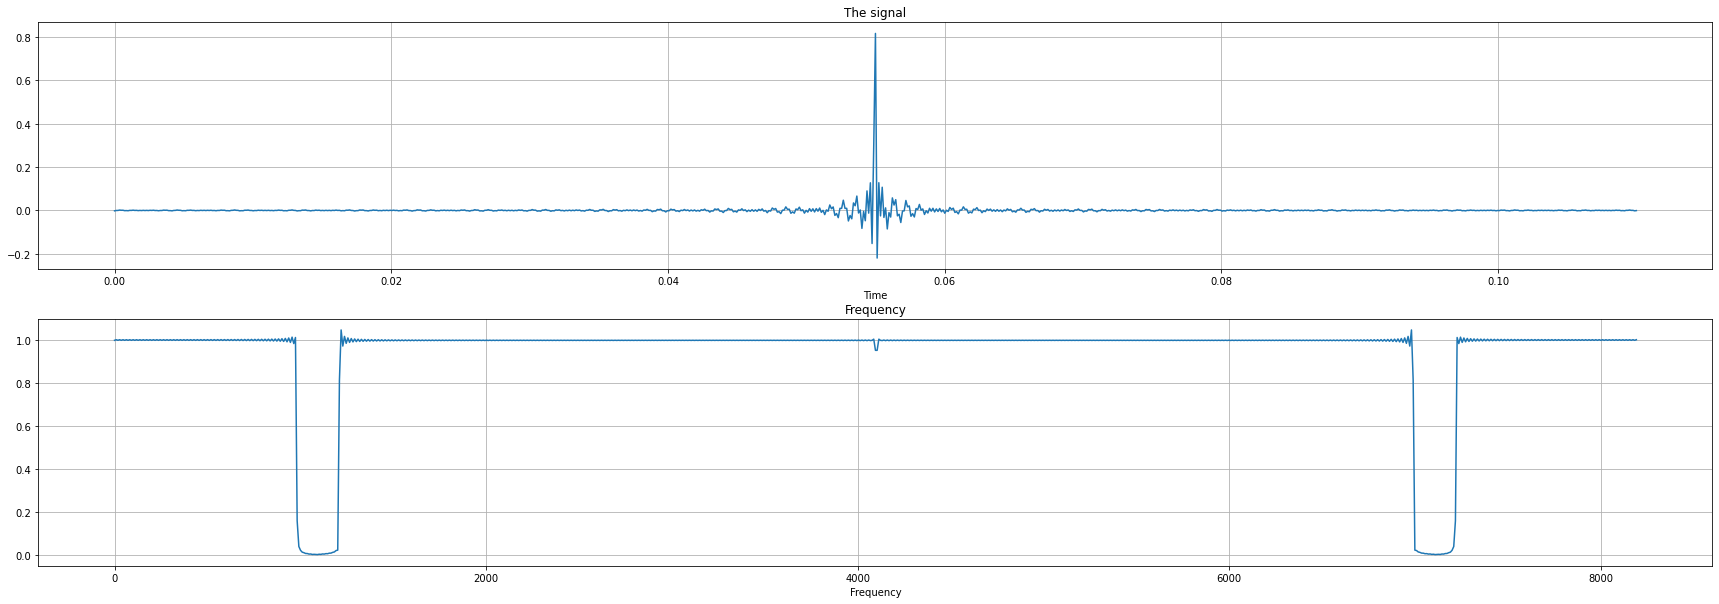

In [5]:
hp = 73
lp = 29
def filterCreator(hp, lp, N, fs):
    x = np.linspace(-7.85*hp, 7.86*hp, N)
    lowPassFilter = np.sin(x) / x
    nm = np.sum(lowPassFilter)
    lowPassFilter /= nm
    #freqplot(lowPassFilter, fs, N)

    x1 = np.linspace(-7.85*lp, 7.86*lp, N)
    lowPassFilter1 = np.sin(x1) / x1
    nm1 = np.sum(lowPassFilter1)
    lowPassFilter1 /= nm1
    #freqplot(lowPassFilter1, fs, N)

    bandPassFilter = lowPassFilter - lowPassFilter1
    #freqplot(bandPassFilter, fs, N)
    
    
    filters = [bandPassFilter, lowPassFilter]
    return filters
filters = filterCreator(hp, lp, 901, fs)
bandPassFilter = filters[0]
freqplot(bandPassFilter, fs, 901)

allPassFilter = (filterCreator(180, lp, 901, fs))[1]
bandPassFilter2 = (filterCreator(53,43, 901, fs))[0]
notchFilter = allPassFilter - bandPassFilter2
freqplot(notchFilter, fs, 901)

# i created a band pass filter and a notch filter in order to filter the noise

Applying the filter to the signal:

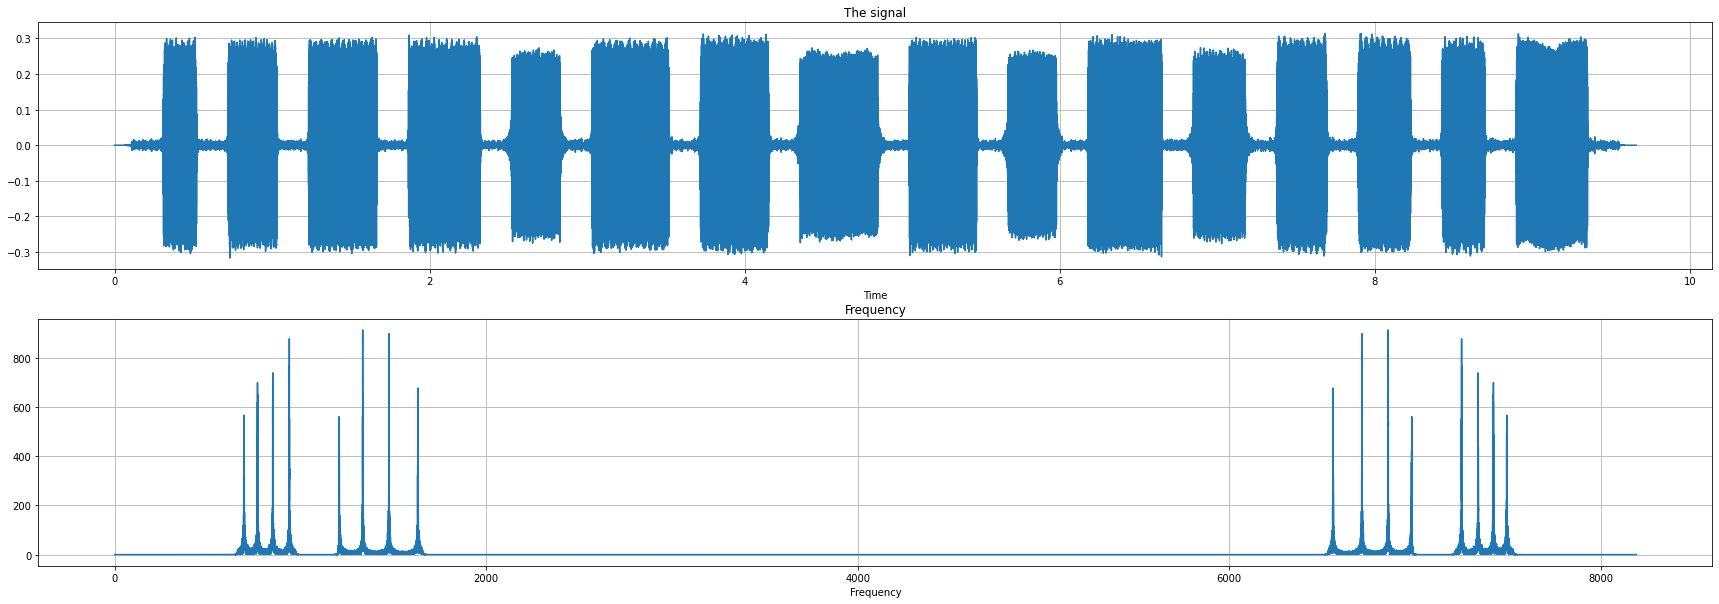

In [6]:
data_reducted = np.convolve(data, bandPassFilter)
data_reducted /= 100000
data_reducted = np.convolve(data_reducted, notchFilter)
freqplot(data_reducted, fs, data_reducted.shape[0])

#sd.play(data_reducted[0:100000], fs)
#sd.wait()

Music.write_mp3('musics/noise_reducted.mp3', fs, data_reducted, normalized = True)

## Decrypting file "encrypted.wav"

In [7]:
fs, data = wavfile.read('musics/encrypted.wav')
#sd.play(data[0:100000], fs)
#sd.wait()

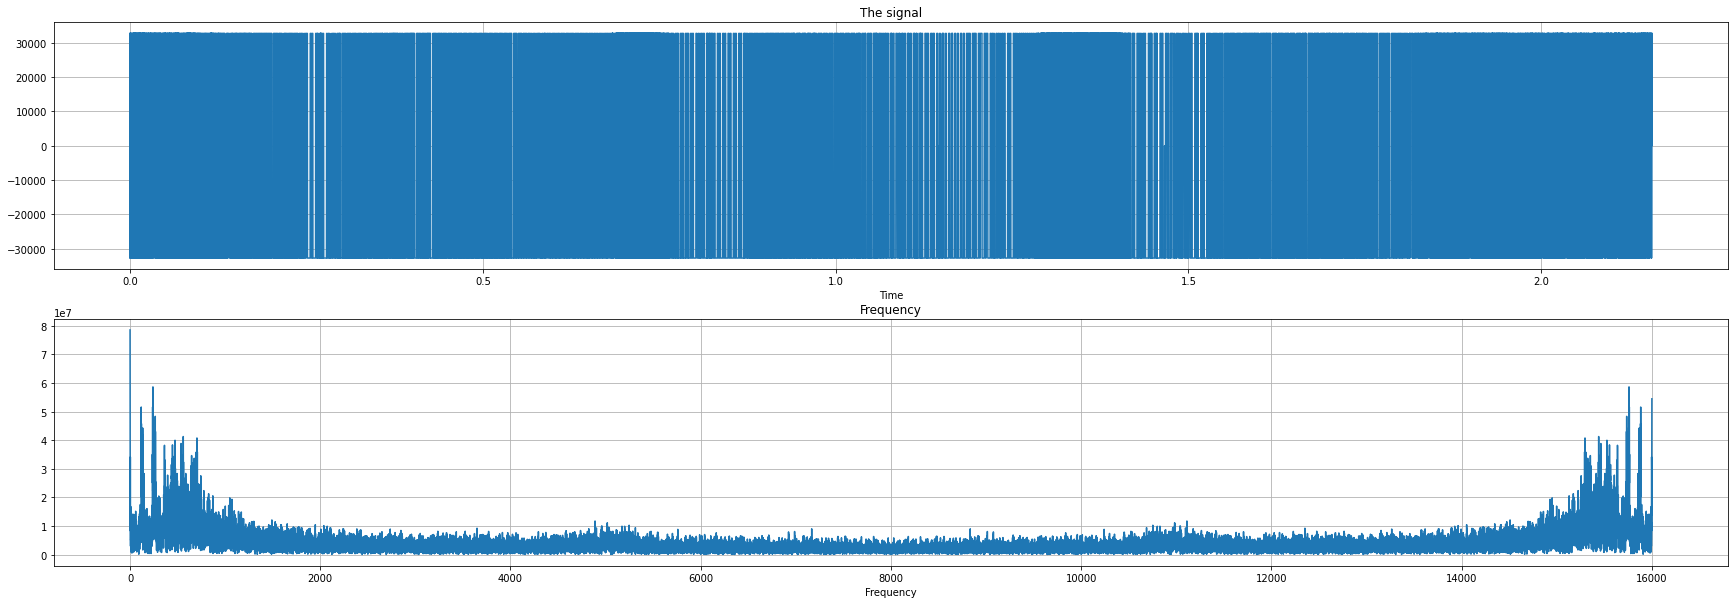

In [8]:
length = data.shape[0]/fs
t = np.linspace(0, length, data.shape[0])
data_fft = np.fft.fft(data)
p = np.linspace(0, fs, data.shape[0])
freqplot(data, fs, data.shape[0])

Rewinding the sound

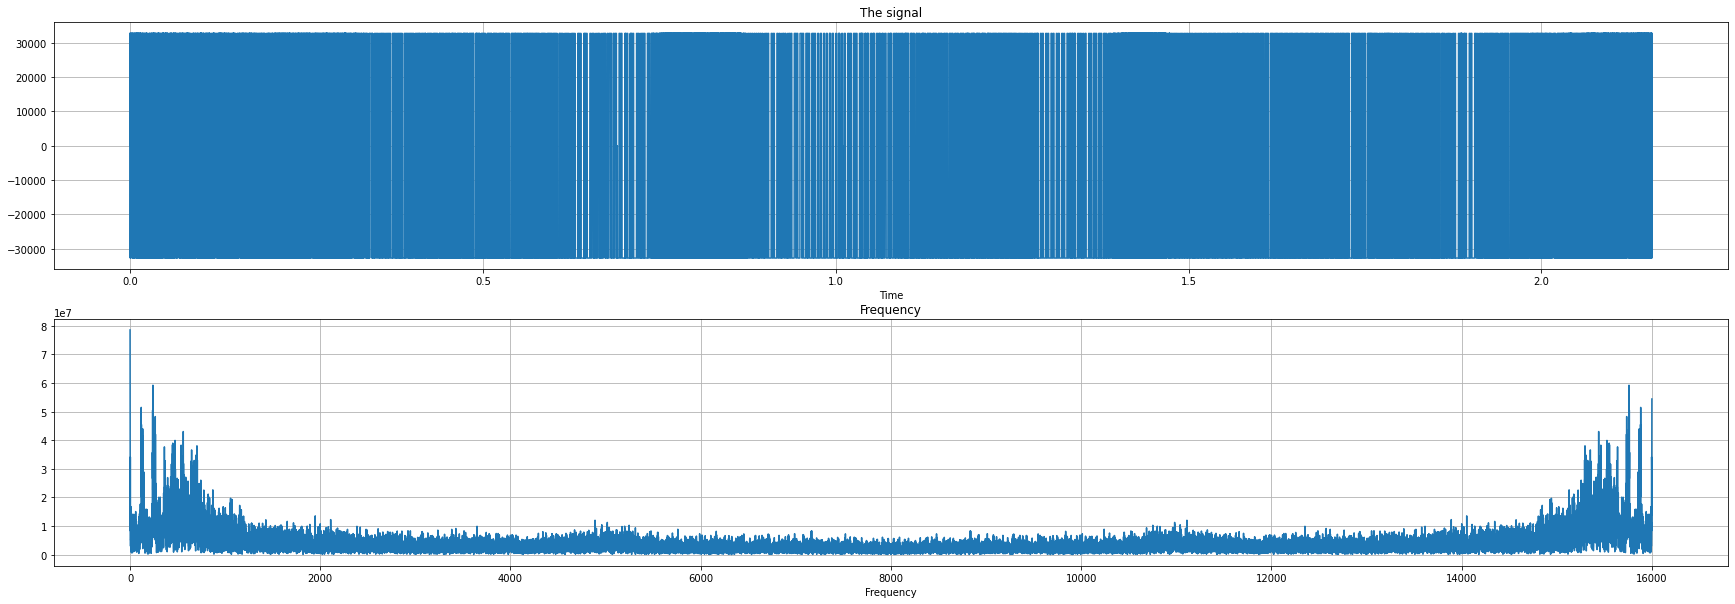

In [123]:
data = data[data.shape[0]:0:-1]
data = np.array(data)
freqplot(data, fs, data.shape[0])
sd.play(data[0:100000], fs)

Creating the filters needed, first we need to filter the noise

In [124]:
def filtered_signal_generator(data, low, high, fs, order = 2):
    filtered_signal1 = butter_bandpass_filter(data, low, high, fs, order)
    filtered_signal1 *= 5
    filtered_signal1 /= 100000
    freqplot(filtered_signal1, fs, 2000)
    return filtered_signal1

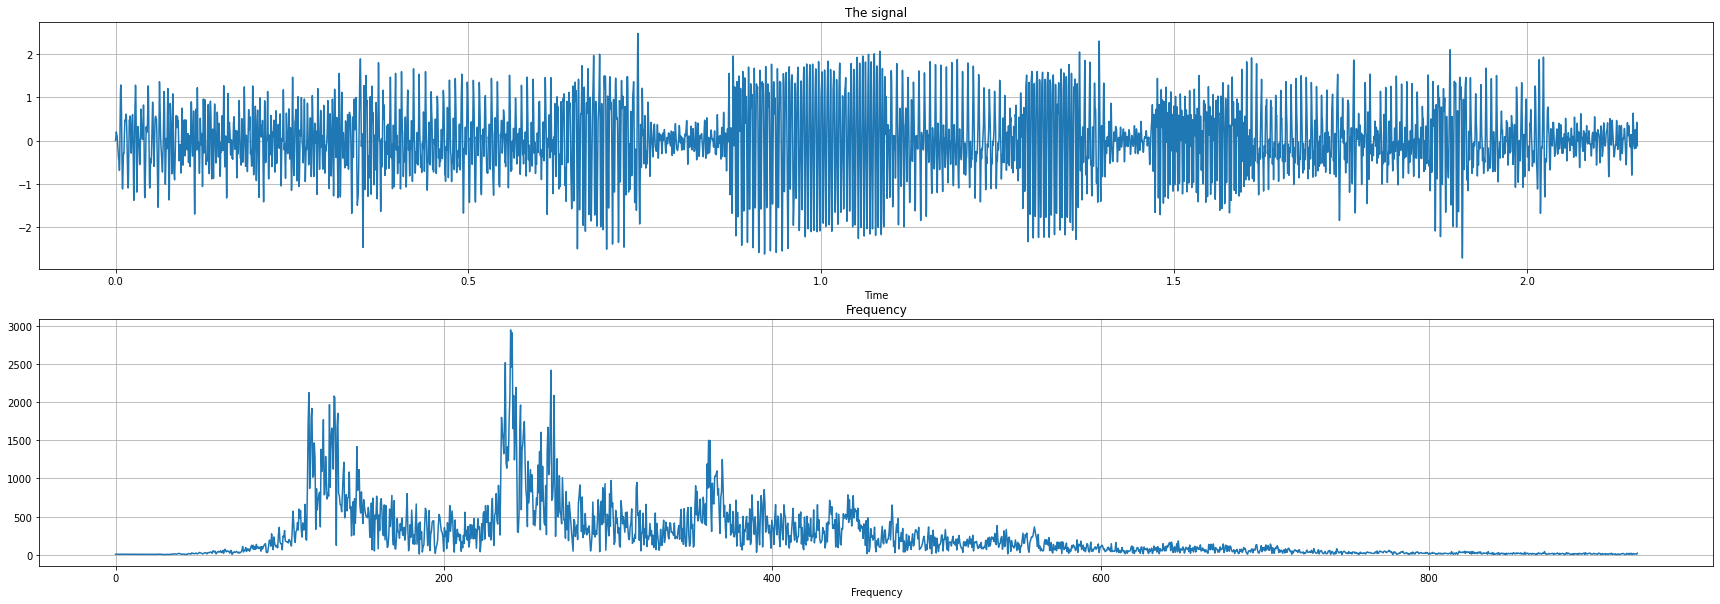

In [129]:
filtered_signal = filtered_signal_generator(data, 110, 380, fs , 3)
filtered_signal /= 10

# cut_freq = 1000
# lowPass = (filterCreator(cut_freq / fs * 180, 180, 901, fs))[1]
# freqplot(lowPass, fs, lowPass.shape[0])

        

Music.write_mp3('musics/decrypted.mp3', fs, filtered_signal, normalized = True)

### The output is :
<h4>درس سیگنال ۳ واحد است</h4>